# Otimizando a extração de ouro

Este projeto teve o objetivo de identificar os melhores preditores (características) da concentração de ouro extraída do minério de ouro. Para isso, o projeto desenvolveu um protótipo de modelo de aprendizado de máquina. O modelo utilizou dados cedidos pela Zyfra, empresa que desenvolve soluções de eficiência para a indústria pesada.

## Importando bibliotecas e dados

In [1]:
### importando bibliotecas
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt

In [2]:
### importando dados
gold_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_full = pd.read_csv('/datasets/gold_recovery_full.csv')

## Processando dados

In [3]:
### indexando pela data
gold_full = gold_full.set_index("date")
gold_test = gold_test.set_index('date')
gold_train = gold_train.set_index('date')

**Comentário**: Indexei os dados de todos os conjuntos à data de extração;

### Verificando dados faltantes

In [4]:
gold_train.isna().sum()

final.output.concentrate_ag                     72
final.output.concentrate_pb                     72
final.output.concentrate_sol                   370
final.output.concentrate_au                     71
final.output.recovery                         1521
                                              ... 
secondary_cleaner.state.floatbank5_a_level      85
secondary_cleaner.state.floatbank5_b_air        85
secondary_cleaner.state.floatbank5_b_level      84
secondary_cleaner.state.floatbank6_a_air       103
secondary_cleaner.state.floatbank6_a_level      85
Length: 86, dtype: int64

In [5]:
gold_test.isna().sum()

primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257
rougher.input.floatbank10_xanthate            123


In [6]:
gold_full.isna().sum()

final.output.concentrate_ag                     89
final.output.concentrate_pb                     87
final.output.concentrate_sol                   385
final.output.concentrate_au                     86
final.output.recovery                         1963
                                              ... 
secondary_cleaner.state.floatbank5_a_level     101
secondary_cleaner.state.floatbank5_b_air       101
secondary_cleaner.state.floatbank5_b_level     100
secondary_cleaner.state.floatbank6_a_air       119
secondary_cleaner.state.floatbank6_a_level     101
Length: 86, dtype: int64

**Comentário**: Existem dados faltantes em todos os conjuntos de dados. 

In [7]:
var_lack_train = gold_full.columns.difference(gold_train.columns).tolist()
print(f"Número de variáveis que faltam no conjunto de treino:", len(var_lack_train) )

Número de variáveis que faltam no conjunto de treino: 0


In [8]:
var_lack_test = gold_full.columns.difference(gold_test.columns).tolist()
print(f"Número de variáveis que faltam no conjunto de teste:", len(var_lack_test) )

Número de variáveis que faltam no conjunto de teste: 34


In [9]:
gold_full.columns.difference(gold_test.columns).tolist()

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

**Comentário**: O conjunto de treino não possuem algumas variáveis presentes no conjunto completo. Essas variáveis abrangem todas as etapas do processo de extração do ouro.

### Tratando dados faltantes

In [10]:
def replace_na(df_tar, df_ref):
    ## todas as variáveis (características)
    all_vars = df_tar.columns
    ## iterando sobre variáveis
    for var in all_vars:
        median_value = np.nanmedian(df_ref[var]) # calcular mediana
        df_tar[var].fillna(value= median_value, inplace=True) # inserir mediana no dado faltante
    return(df_tar)

**Comentário**: Defini uma função que preenche os dados faltantes de uma variável com base no valor mediano desta variável em um dataframe de referência.

In [11]:
### taratando dados faltantes no conjunto completo
gold_full = replace_na(df_tar= gold_full, df_ref = gold_full)
### checando tratamento
print(f"Dados faltantes no conjunto completo:", sum(gold_full.isna().sum()) )

Dados faltantes no conjunto completo: 0


In [12]:
### taratando dados faltantes no conjunto de treino
gold_train = replace_na(df_tar= gold_train, df_ref = gold_full)
### checando tratamento
print(f"Dados faltantes no conjunto de treino:", sum(gold_train.isna().sum()) )

Dados faltantes no conjunto de treino: 0


In [13]:
### taratando dados faltantes no conjunto de teste
gold_test = replace_na(df_tar= gold_test, df_ref = gold_full)
### checando tratamento
print(f"Dados faltantes no conjunto de teste:", sum(gold_test.isna().sum()) )

Dados faltantes no conjunto de teste: 0


In [14]:
### adicionando variáveis que faltam no conjunto de teste
gold_test = gold_test.join(other=gold_full[var_lack_test], how='left')

**Comentário**: No tratamento dos dados faltantes eu:
- Subtitui os dados faltantes em cada variável pela respectiva mediana da variável:
 - Primeiro, no conjunto completo, utilizei a mediana calculada no próprio conjunto completo;
 - Depois, nos demais conjuntos, utilizei a mediana calculada no conjunto completo;
- Adicionei as variábeis faltantes no conjunto de teste a partir do conjunto completo;

## Análise exploratória dos dados

### Distribuição do produto da flotação

<AxesSubplot:>

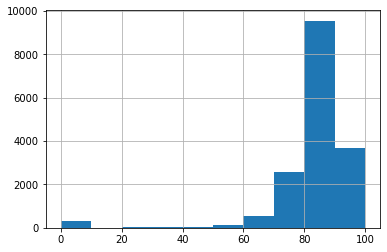

In [15]:
### visualizando distribuição
gold_train["rougher.output.recovery"].hist()

In [16]:
gold_train["rougher.output.recovery"].describe()

count    16860.000000
mean        82.966475
std         13.962389
min          0.000000
25%         80.922825
50%         86.144121
75%         89.343361
max        100.000000
Name: rougher.output.recovery, dtype: float64

**Comentário**: A variável de produtos da flotação (`rougher.output.recovery`) possui uma distribuição assimétrica à esquerda, ou seja, valores pequenos são mais raros.

### Relação do produto de flotação com outras variáveis

In [17]:
def fast_lm_evaluation(df, target_name):
    ## vetores de resultado
    all_mean_predict = []
    all_mae = []
    ## separando objetivos e características
    target = df[target_name]
    features = df.drop(target_name,  axis = 1)
    ## dividindo em treino e validação
    target_train, target_valid, features_train, features_valid = train_test_split(target, features, train_size = 0.75, random_state = 42)
    ## todas as possíveis características
    all_feature_names = features.columns.tolist()
    ## iterando sobre características
    for feature_name in all_feature_names:
        ## selecionando apenas uma característica
        one_feature_train = pd.DataFrame(features_train[feature_name])
        one_feature_valid = pd.DataFrame(features_valid[feature_name])
        ## ajustando modelo
        lm = LinearRegression().fit(one_feature_train, target_train)
        ## predizendo
        prediction = lm.predict(one_feature_valid)
        mean_predict = np.mean(prediction)
        all_mean_predict.append(mean_predict)
        ## avaliando predição 
        mae = mean_absolute_error(target_valid, prediction)
        all_mae.append(mae)
    ## organizando resutlados
    eval_df = pd.DataFrame({"feature": all_feature_names, "predicted_target_mean":all_mean_predict, "mae": all_mae })
    ## exportando resultados
    return eval_df

**Comentário**: Defini uma função para verificar o poder de predição de diferentes características sobre um dado objetivo com base em regressão linear. Para isso, a função:
- Separa o objetivo das características;
- Dividi o objetivo e as características em treino (75%) e validação (25%)
- Itera sobre cada característica:
 - Separa a característica de treino e validação;
 - Ajusta o modelo linear com o objetivo e característica de treino;
 - Prediz os valores com base na característica de validação;
 - Calcula a média dos valores preditos;
 - Calcula o erro médio absoluto (EAM) entre os valores preditos e o objetivo de validação;

In [18]:
### aplicando função de avaliação sobre a produto de flotação
eval_1 = fast_lm_evaluation(df= gold_train, target_name="rougher.output.recovery")

In [19]:
### visualziando em ordem de ajuste
eval_1.sort_values(by="mae", ascending=True)

,feature,predicted_target_mean,mae
50,rougher.output.tail_au,82.961406,6.177021
4,final.output.recovery,83.037171,6.930795
48,rougher.output.tail_pb,83.063541,6.990238
9,primary_cleaner.input.sulfate,83.072925,7.167408
47,rougher.output.tail_ag,82.983909,7.217244
...,...,...,...
40,rougher.input.floatbank10_xanthate,83.042527,7.696997
43,rougher.output.concentrate_ag,83.086269,7.785061
44,rougher.output.concentrate_pb,83.045480,8.069754
45,rougher.output.concentrate_sol,83.090950,8.082958


**Comentário**: Todas as características predizem uma média similar para o produto da flotação. Contudo, algumas características fazem a predição com menor error.

### Concentração dos metais ao longo das etapas de mineração

In [20]:
### definindo função para separar as variáveis relativas a um determinado metal
def get_metal_vars(df, metal_name):
    metal_var_names =[]
    all_var_names = df.columns.tolist()
    for one_var_name in all_var_names:
        if (metal_name in one_var_name) and ("calculation" not in one_var_name):
            metal_var_names.append(one_var_name)
    return(metal_var_names)

In [21]:
### definindo função para ordenar variáveis segundo processo de mineração
def order_metal_vars(metal_var_names):
    ordered_var_names = ["NA"] * 4
    for one_var_name in metal_var_names:
        if "rougher.input.feed" in one_var_name:
            ordered_var_names[0] = one_var_name
        elif "rougher.output.concentrate" in one_var_name:
            ordered_var_names[1] = one_var_name
        elif "primary_cleaner.output.concentrate" in one_var_name:
            ordered_var_names[2] = one_var_name
        elif "final.output.concentrate" in one_var_name:
            ordered_var_names[3] = one_var_name
    return(ordered_var_names)

In [22]:
### definindo função para avaliar visualmente a concentração do metal 
def fast_boxplot(df, select_vars):
    vec0 = df[select_vars].iloc[:,0]
    vec1 = df[select_vars].iloc[:,1]
    vec2 = df[select_vars].iloc[:,2]
    vec3 = df[select_vars].iloc[:,3]
    plt.boxplot([vec0, vec1, vec2, vec3])
    plt.xticks([1, 2, 3, 4], ['rougher_input', 'rougher_output', "primary_output", "final_output"])
    plt.show()

**Comentário**: Defini três funções:
- A primeira separa as variáveis que descrevem a concentraçaõ de um metal antes e depois das etapas de mineração;
- A segunda ordena as variáveis de modo a refletir as etapas do processo de mineração;
- A terceira mostra por boxplot a concentração do metal ao longo de cada etapa da mineração;

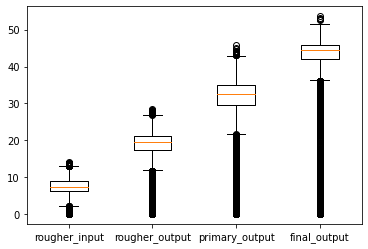

In [23]:
### descrevendo a concentração de ouro (Au)
au_vars = get_metal_vars(df=gold_train, metal_name="au")
order_au_vars = order_metal_vars(au_vars)
fast_boxplot(df=gold_train, select_vars=order_au_vars)

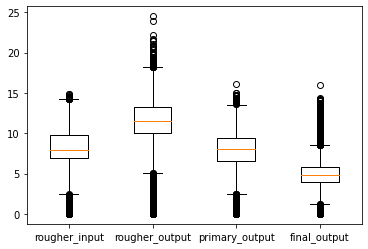

In [24]:
### descrevendo a concentração de prata (Ag)
ag_vars = get_metal_vars(df=gold_train, metal_name="ag")
order_ag_vars = order_metal_vars(ag_vars)
fast_boxplot(df=gold_train, select_vars=order_ag_vars)

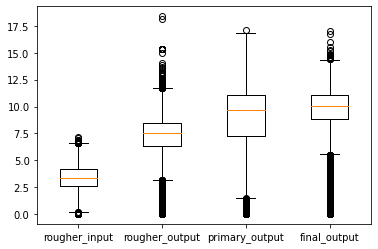

In [25]:
### descrevendo a concentração de chumbo (Pb)
pb_vars = get_metal_vars(df=gold_train, metal_name="pb")
order_pb_vars = order_metal_vars(pb_vars)
fast_boxplot(df=gold_train, select_vars=order_pb_vars)

**Comentário**: A concentração de ouro (Au) aumenta a cada etapa da mineração, assim como a de chumbo (Pb). Não há padrão para a concentraçaõ de prata (Ag). Assim, a concentração de chumbo é um possível indicador da concentração de ouro que é conseguida ao fim do processo de mineração.

### Tamanho das partículas de minério

O tamanho das partículas de minério é uma proxy para a quantidade de material que foi minerado no conjunto de dados. Essa quantidade deve ser similar no conjunto de treino e teste, indicando que ambos conjuntos representam um cenário similar de mineração.

Com base nisso, testatei se o tamanho das partículas de minério diferem entre o conjunto de treino e teste, considerando duas hipóteses:

- H0) O tamanho médio das partículas de minério não difere entre os conjuntos de treino e teste;
- H1) O tamanho médio das partículas de minério difere entre os conjuntos de treino e teste;

In [26]:
### separando valroes de tamanho no conjunto de treino e teste
size_train = gold_train["rougher.input.feed_size"]
size_test = gold_test["rougher.input.feed_size"]

In [27]:
### limiar de significância
alpha = 0.05

In [28]:
### KS teste para verificar a igualdade de duas distribuições
kstest = stats.kstest(size_train , size_test)
pvalue = kstest.pvalue
if pvalue > alpha:
    print("O tamanho das partículas de minério é igual entre o conjunto de treino e teste")
elif pvalue < alpha:
    print("O tamanho das partículas de minério difere entre o conjunto de treino e teste")

O tamanho das partículas de minério difere entre o conjunto de treino e teste


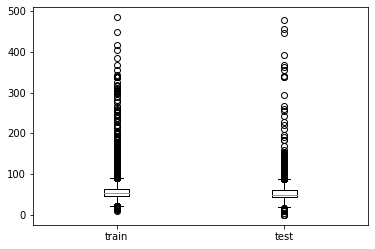

In [29]:
### comparando distribuição entre treino e teste
plt.boxplot([size_train, size_test ])
plt.xticks([1, 2,], ['train', 'test'])
plt.show()

**Comentário**: A distribuição de valores para o tamanho do minério difere entre os conjuntos de treino e teste. Assim, os valores encontrados em um conjunto podem estar ausentes no outro conjunto, diminuindo o poder de predição de modelos de aprendizado de máquina. Isto requer um tratamento da distribuição dos dados.

### Distribuição dos valores de concentração de ouro

<AxesSubplot:>

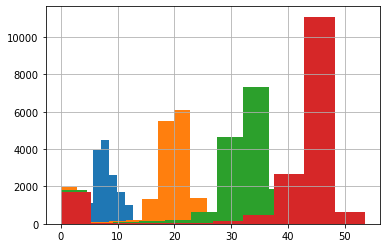

In [30]:
gold_train[order_au_vars[0]].hist()
gold_train[order_au_vars[1]].hist()
gold_train[order_au_vars[2]].hist()
gold_train[order_au_vars[3]].hist()

<AxesSubplot:>

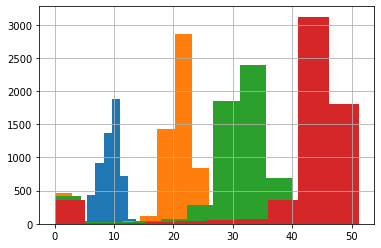

In [31]:
gold_test[order_au_vars[0]].hist()
gold_test[order_au_vars[1]].hist()
gold_test[order_au_vars[2]].hist()
gold_test[order_au_vars[3]].hist()

**Comentário**: A concentração de ouro mostra uma distribuição bimodal em todas as etapas de extração, sendo uma moda sempre perto de zero. Isto indica que um número considerável de amostras de minério resulta em baixas concentrações de ouro, independente da etapa. Estes valores devem refletir um erro inerente do processo de mineração que gera amostras de baixa concentração. 

Vou retirar esses valores dos dados, pois eles não refletem concentrações de ouro que de alguma forma estão atreladas a qualidade do minério ou do processo de mineraçaõ.

In [32]:
### definindo função para remoçaõ de valores extremos
def remove_outlier(df_tar, df_ref, var):
    q1 = df_ref[var].quantile(0.25)
    q3 = df_ref[var].quantile(0.75)
    iqr = q3 - q1
    lim_min = q1 - (1.5* iqr)
    lim_max = q3 + (1.5* iqr)
    df_clean = df_tar[(df_tar[var] > lim_min) & (df_tar[var] < lim_max)]
    return(df_clean)

In [33]:
### aplicando função ao conjunto de treino
cgold_train = gold_train
for one_au_var in order_au_vars:
    cgold_train = remove_outlier(df_tar= cgold_train, df_ref = gold_full, var = one_au_var)

In [34]:
### aplicando função ao conjunto de teste
cgold_test = gold_test
for one_au_var in order_au_vars:
    cgold_test = remove_outlier(df_tar= cgold_test, df_ref = gold_full, var = one_au_var)

<AxesSubplot:>

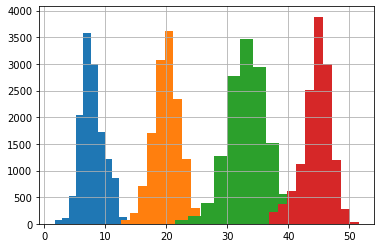

In [35]:
### verificando distribuição
cgold_train[order_au_vars[0]].hist()
cgold_train[order_au_vars[1]].hist()
cgold_train[order_au_vars[2]].hist()
cgold_train[order_au_vars[3]].hist()

<AxesSubplot:>

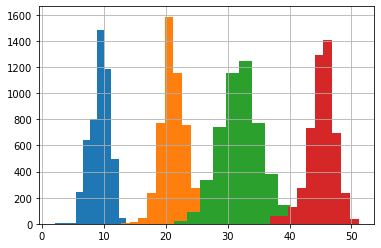

In [36]:
### verificando distribuição
cgold_test[order_au_vars[0]].hist()
cgold_test[order_au_vars[1]].hist()
cgold_test[order_au_vars[2]].hist()
cgold_test[order_au_vars[3]].hist()

**Comentário**: Eu removi observações que continham valores extremos pequenos ao longo de todas as variáveis de concentração de ouro (etapas da mineração). Eu extrai as observações com base nos limites inferior e superior (1.5 x quartile 1 e quartile 3, respectivamente) calculados sobre o conjunto completo de dados. Após a remoção, os dados de treino e teste mostraram uma distribuição unimodal aproximadamente simétricas em todas as variáveis de concentração de ouro.

## Predizendo a extração de ouro

### Cálculo do sMAPE

In [37]:
def smape_calculation(df, target_var, n_splits):
    ## separando objetivos e características no treino
    target = df[target_var]
    features = df.drop(target_var,  axis = 1)
    ## vetor com resultados
    best_smape = float('inf')
    ## dividindo em K amostras
    x = range(0, len(target))
    kf = KFold(n_splits = n_splits)
    for train_index, valid_index in kf.split(x):
    ## dividindo em treino e validação 
        target_train = target.iloc[train_index]
        target_valid = target.iloc[valid_index]
        features_train = features.iloc[train_index]
        features_valid = features.iloc[valid_index]
        ## ajustando modelo
        lm = LinearRegression().fit(features_train, target_train)
        ## predizendo
        prediction = pd.Series(lm.predict(features_valid))
        ## cálculo do sMAPE
        # diferença entre obsevado e predição
        diff = [ abs( a - b) for a, b in zip(target_valid, prediction) ] 
        # média simétrica
        sym_mean = [ (abs(a) + abs(b))/2 for a, b in zip(target_valid, prediction) ] 
        # proporção entre diferença e média
        proportion = [ (a/ b) for a, b in zip(diff, sym_mean) ]
        # sMAPE
        smape = (sum(proportion) / len(proportion) )
        ## Avaliando modelo 
        if smape < best_smape: 
            best_smape = smape
        ## exportando resultado
    return(best_smape)

**Comentário**: Defini uma função para avaliar modelos lineares que predizem a retirada de ouro. Para isso, a função:
- separa o objetivo das características;
- dividide o objetivo e características em k partes, onde uma parte é validação e as demais são treino;
- ajusta um modelo linear com as parte de treino;
- utiliza o modelo linear para prever os valores da parte de validação;
- calcula os erros da predição com base no sMAPE;
- retorna o modelo linear com o menor valor de sMAPE;

### Ajustando modelos alternartivos

In [38]:
### preparando dados para modelo completo
cgold_train_full_r = cgold_train.drop("final.output.recovery",  axis = 1)
cgold_train_full_f = cgold_train.drop("rougher.output.recovery",  axis = 1)

In [39]:
### sMAPE para o modelo completo
smape_full_r = smape_calculation(df = cgold_train_full_r, target_var = "rougher.output.recovery", n_splits=3)
smape_full_f = smape_calculation(df = cgold_train_full_f, target_var = "final.output.recovery", n_splits=3)
smap_final_full = (0.25*smape_full_r) + (0.75*smape_full_f)
print("O sMAP final do modelo completo:", round(smap_final_full,2)) 

O sMAP final do modelo completo: 0.03


In [40]:
### reduzindo número de características
var_set_1 = pb_vars
var_set_1.append("rougher.output.recovery")
var_set_1.append("final.output.recovery")

In [41]:
### preparando conjunto de dados para modelo reduzido
cgold_train_red = cgold_train[var_set_1]
cgold_train_red_r = cgold_train_red.drop("final.output.recovery",  axis = 1)
cgold_train_red_f = cgold_train_red.drop("rougher.output.recovery",  axis = 1)

In [42]:
### calculando sMAPE para o modelo reduzido
smape_red_r = smape_calculation(df = cgold_train_red_r, target_var = "rougher.output.recovery", n_splits=3)
smape_red_f = smape_calculation(df = cgold_train_red_f, target_var = "final.output.recovery", n_splits=3)
smap_final_red = (0.25*smape_red_r) + (0.75*smape_red_f)
print("O sMAP final do modelo reduzido:", round(smap_final_red,2)) 

O sMAP final do modelo reduzido: 0.06


In [43]:
cgold_train_full_r.shape

(13254, 85)

**Comentário**: Comparei dois modelos de regressão linear que predizem a concentração de ouro com base na métrica SMAP:

- O primeiro modelo inclui todas as características disponíveis = modelo completo;
- O segundo modelo possui apenas as características relativas a concentração de chumbo = modelo reduzido;

O modelo completo apresentou um valor de SMAP duas vezes menor que o modelo reduzido, indicando um menor erro percentual nas suas predições. Contudo, o modelo completo possui 20 vezes mais caraterísticas (parâmetros) que o modelo reduzido, o que indica uma complexidade adicional que não retorna numa melhor predição. O teste dos modelos com dados desconhecidos pode indicar qual tem uma melhor performace preditiva.

### Testando modelos

In [44]:
### defindindo função para calcular sMAPE com base nos conjuntos de treino e teste
def smape_test(df_train, df_test, target_var):
    ## separando objetivos e características no treino
    target_train = df_train[target_var]
    features_train = df_train.drop(target_var,  axis = 1)
    ## separando objetivos e características no teste
    target_test = df_test[target_var]
    features_test = df_test.drop(target_var,  axis = 1)
    ## ajustando modelo
    lm = LinearRegression().fit(features_train, target_train)
    ## predizendo
    prediction = pd.Series(lm.predict(features_test))
    ## cálculo do sMAPE
    # diferença entre obsevado e predição
    diff = [ abs( a - b) for a, b in zip(target_test, prediction) ] 
    # média simétrica
    sym_mean = [ (abs(a) + abs(b))/2 for a, b in zip(target_test, prediction) ] 
    # proporção entre diferença e média
    proportion = [ (a/ b) for a, b in zip(diff, sym_mean) ]
    # sMAPE
    smape = (sum(proportion) / len(proportion) )
    ## exportando resultado
    return(smape)

**Comentário**: Defini uma função para testar modelos lineares que predizem a retirada de ouro. Para isso, a função:
- separa o objetivo das características nos conjuntos de treino e teste;
- ajusta um modelo linear com base no objetivo e característcas de treino;
- utiliza o modelo linear para prever o objetivo com base nas características de teste;
- calcula os erros da predição com base no sMAPE;

In [45]:
### preparando conjuntos de teste para o modelo completo
cgold_test_full_r = cgold_test.drop("final.output.recovery",  axis = 1)
cgold_test_full_f = cgold_train.drop("rougher.output.recovery",  axis = 1)

In [46]:
### calculando sMAPE para o modelo completo
test_smape_full_r = smape_test(df_train = cgold_train_full_r , df_test = cgold_test_full_r, target_var= "rougher.output.recovery")
test_smape_full_f = smape_test(df_train = cgold_train_full_f , df_test = cgold_test_full_f, target_var= "final.output.recovery")
test_smap_final_full = (0.25*test_smape_full_r) + (0.75*test_smape_full_f)
print("O sMAP final do modelo completo:", round(test_smap_final_full,2)) 

O sMAP final do modelo completo: 0.5


In [47]:
### preparando conjunto de teste para o modelo reduzido
cgold_test_red = cgold_test[var_set_1]
cgold_test_red_r = cgold_test_red.drop("final.output.recovery",  axis = 1)
cgold_test_red_f = cgold_test_red.drop("rougher.output.recovery",  axis = 1)

In [48]:
### calculando sMAPE para o modelo reduzido
test_smape_red_r = smape_test(df_train = cgold_train_red_r , df_test = cgold_test_red_r, target_var= "rougher.output.recovery")
test_smape_red_f = smape_test(df_train = cgold_train_red_f , df_test = cgold_test_red_f, target_var= "final.output.recovery")
test_smap_final_red = (0.25*test_smape_red_r) + (0.75*test_smape_red_f)
print("O sMAP final do modelo reduzido:", round(test_smap_final_red,2)) 

O sMAP final do modelo reduzido: 0.06


# Conclusão

Testei dois modelos de regressão linear que predizem a concentração de ouro com base na métrica SMAP:

- O primeiro modelo inclui todas as características disponíveis = modelo completo;
- O segundo modelo possui apenas as características relativas a concentração de chumbo = modelo reduzido;

O modelo completo apresentou um valor de SMAP muito maior que o do modelo reduzido, indicando que o modelo completo possui uma poder de predição menor sobre a concentração de ouro extraída. Baseado nisto, o modelo reduzido é o mais adequado para predizer a concentração de ouro extraído.